##### Import All necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import kagglehub

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler,OrdinalEncoder
from sklearn.pipeline import Pipeline


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor, callback
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score, mean_squared_error


from sklearn.cluster import KMeans

import joblib

### Download dataset from kaggle

In [2]:
path = kagglehub.dataset_download("krishangupta33/pharmaceutical-company-wholesale-retail-data")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\88017\.cache\kagglehub\datasets\krishangupta33\pharmaceutical-company-wholesale-retail-data\versions\1


In [3]:
files = os.listdir(path)
print("Files Folder:", files)

Files Folder: ['pharma-data.csv']


### Load dataset

In [4]:
file_path=os.path.join(path,"pharma-data.csv")
df=pd.read_csv(file_path)
df.head()

,Distributor,Customer Name,City,Country,Latitude,Longitude,Channel,Sub-channel,Product Name,Product Class,Quantity,Price,Sales,Month,Year,Name of Sales Rep,Manager,Sales Team
0,Gottlieb-Cruickshank,"Zieme, Doyle and Kunze",Lublin,Poland,51.2333,22.5667,Hospital,Private,Topipizole,Mood Stabilizers,4.0,368,1472.0,January,2018,Mary Gerrard,Britanny Bold,Delta
1,Gottlieb-Cruickshank,Feest PLC,Świecie,Poland,53.4167,18.4333,Pharmacy,Retail,Choriotrisin,Antibiotics,7.0,591,4137.0,January,2018,Jessica Smith,Britanny Bold,Delta
2,Gottlieb-Cruickshank,Medhurst-Beer Pharmaceutical Limited,Rybnik,Poland,50.0833,18.5000,Pharmacy,Institution,Acantaine,Antibiotics,30.0,66,1980.0,January,2018,Steve Pepple,Tracy Banks,Bravo
3,Gottlieb-Cruickshank,Barton Ltd Pharma Plc,Czeladź,Poland,50.3333,19.0833,Hospital,Private,Lioletine Refliruvax,Analgesics,6.0,435,2610.0,January,2018,Mary Gerrard,Britanny Bold,Delta
4,Gottlieb-Cruickshank,Keeling LLC Pharmacy,Olsztyn,Poland,53.7800,20.4942,Pharmacy,Retail,Oxymotroban Fexoformin,Analgesics,20.0,458,9160.0,January,2018,Anne Wu,Britanny Bold,Delta


### Basic cleaning and data preparation

In [5]:
df.drop_duplicates(inplace=True)

In [6]:
df.describe()

,Latitude,Longitude,Quantity,Price,Sales,Year
count,254078.000000,254078.000000,254078.000000,254078.000000,2.540780e+05,254078.000000
mean,50.962216,10.803216,112.873680,412.210510,4.643841e+04,2018.385193
std,1.625536,4.143295,744.316142,224.963357,3.491945e+05,1.041356
min,47.514200,6.083800,-7200.000000,22.000000,-4.161600e+06,2017.000000
25%,49.805600,7.891100,5.000000,195.000000,1.704000e+03,2018.000000
50%,51.133300,9.397800,20.000000,430.000000,5.850000e+03,2018.000000
75%,52.083300,12.133300,50.000000,605.000000,2.159175e+04,2019.000000
max,54.781900,23.566700,117600.000000,794.000000,7.420560e+07,2020.000000


In [7]:
print(df.isnull().sum())

Distributor          0
Customer Name        0
City                 0
Country              0
Latitude             0
Longitude            0
Channel              0
Sub-channel          0
Product Name         0
Product Class        0
Quantity             0
Price                0
Sales                0
Month                0
Year                 0
Name of Sales Rep    0
Manager              0
Sales Team           0
dtype: int64


In [8]:
#drop high cardinality cols
to_drop=['Customer Name','Name of Sales Rep','Manager','Sales Team','City']
df.drop(columns=to_drop,inplace=True)
df.head()

,Distributor,Country,Latitude,Longitude,Channel,Sub-channel,Product Name,Product Class,Quantity,Price,Sales,Month,Year
0,Gottlieb-Cruickshank,Poland,51.2333,22.5667,Hospital,Private,Topipizole,Mood Stabilizers,4.0,368,1472.0,January,2018
1,Gottlieb-Cruickshank,Poland,53.4167,18.4333,Pharmacy,Retail,Choriotrisin,Antibiotics,7.0,591,4137.0,January,2018
2,Gottlieb-Cruickshank,Poland,50.0833,18.5000,Pharmacy,Institution,Acantaine,Antibiotics,30.0,66,1980.0,January,2018
3,Gottlieb-Cruickshank,Poland,50.3333,19.0833,Hospital,Private,Lioletine Refliruvax,Analgesics,6.0,435,2610.0,January,2018
4,Gottlieb-Cruickshank,Poland,53.7800,20.4942,Pharmacy,Retail,Oxymotroban Fexoformin,Analgesics,20.0,458,9160.0,January,2018


### Data Preprocessing Methodology

This function, `preprocess_dataframe`, takes a raw dataset as a parameter and performs several steps to clean, transform, and generate new features to prepare the data for machine learning models.

In [9]:

def preprocess_dataframe(df):
    df_mod = df.copy()

    df_mod.replace([np.inf, -np.inf], np.nan, inplace=True)

    def cap_outliers(col):
        q1, q3 = df_mod[col].quantile([.25, .75])
        iqr   = q3 - q1
        lower, higher = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        df_mod[col] = df_mod[col].clip(lower, higher)
    for c in ['Quantity','Price','Sales']:
        if c in df_mod:
            cap_outliers(c)

    
    df_mod['Return_Flag'] = (df_mod['Quantity'] < 0).astype(int)
    df_mod['Quantity']    = df_mod['Quantity'].abs()
    df_mod['Sales']       = df_mod['Price'] * df_mod['Quantity']

   
    df_mod['Sales_per_Unit'] = df_mod['Sales'] / df_mod['Quantity']
    df_mod['Log_Sales']      = np.log1p(df_mod['Sales'].clip(lower=1e-5))
    df_mod['unit_price']     = df_mod['Sales'] / df_mod['Quantity']

    
    month_map = {
        "January":1, "February":2, "March":3, "April":4,
        "May":5, "June":6, "July":7, "August":8,
        "September":9, "October":10, "November":11, "December":12
    }
    df_mod['MonthNum']  = df_mod['Month'].map(month_map)
    df_mod['Date']      = pd.to_datetime(
        dict(year=df_mod['Year'], month=df_mod['MonthNum'], day=1)
    )
    df_mod['Month_sin'] = np.sin(2 * np.pi * df_mod['Date'].dt.month / 12)
    df_mod['Month_cos'] = np.cos(2 * np.pi * df_mod['Date'].dt.month / 12)

    
    df_mod.sort_values(['Product Name','Date'], inplace=True)
    g = df_mod.groupby('Product Name')['Quantity']
    df_mod['qty_lag1']  = g.shift(1).fillna(0)
    df_mod['qty_lag2']  = g.shift(2).fillna(0)
    df_mod['qty_roll3'] = (
        g.rolling(window=3, min_periods=1)
         .mean()
         .reset_index(level=0, drop=True)
         .fillna(0)
    )

    
    df_mod.dropna(subset=[
        'Quantity','Price','Sales_per_Unit',
        'Month_sin','Month_cos','Year',
        'qty_lag1','qty_lag2','qty_roll3'
    ], inplace=True)

   
    coords = df_mod[['Latitude','Longitude']]
    df_mod['Region'] = KMeans(n_clusters=5, random_state=42).fit_predict(coords)
    df_mod = pd.get_dummies(df_mod, columns=['Region'], drop_first=True)
    
    cols_to_drop = [
        'Price','Sales','Sales_per_Unit','Log_Sales','Month','MonthNum','Date'
    ]
    df_mod.drop(columns=[c for c in cols_to_drop if c in df_mod.columns],
                inplace=True)

    return df_mod


In [10]:
df_mod=preprocess_dataframe(df)
df_mod.head()

,Distributor,Country,Latitude,Longitude,Channel,Sub-channel,Product Name,Product Class,Quantity,Year,...,unit_price,Month_sin,Month_cos,qty_lag1,qty_lag2,qty_roll3,Region_1,Region_2,Region_3,Region_4
40583,Gerlach LLC,Germany,50.8014,7.2044,Hospital,Private,Abatatriptan,Antibiotics,5.0,2017,...,742.0,0.5,0.866025,0.0,0.0,5.000000,False,False,False,True
41185,Gerlach LLC,Germany,50.6872,10.9142,Pharmacy,Institution,Abatatriptan,Antibiotics,10.0,2017,...,742.0,0.5,0.866025,5.0,0.0,7.500000,False,True,False,False
41443,Erdman,Germany,50.8161,7.1556,Pharmacy,Retail,Abatatriptan,Antibiotics,20.0,2017,...,742.0,0.5,0.866025,10.0,5.0,11.666667,False,False,False,True
41857,Gerlach LLC,Germany,49.3167,6.7500,Pharmacy,Retail,Abatatriptan,Antibiotics,5.0,2017,...,742.0,0.5,0.866025,20.0,10.0,11.666667,False,False,False,True
41871,Gerlach LLC,Germany,51.5426,7.2190,Pharmacy,Retail,Abatatriptan,Antibiotics,24.0,2017,...,742.0,0.5,0.866025,5.0,20.0,16.333333,False,False,False,True


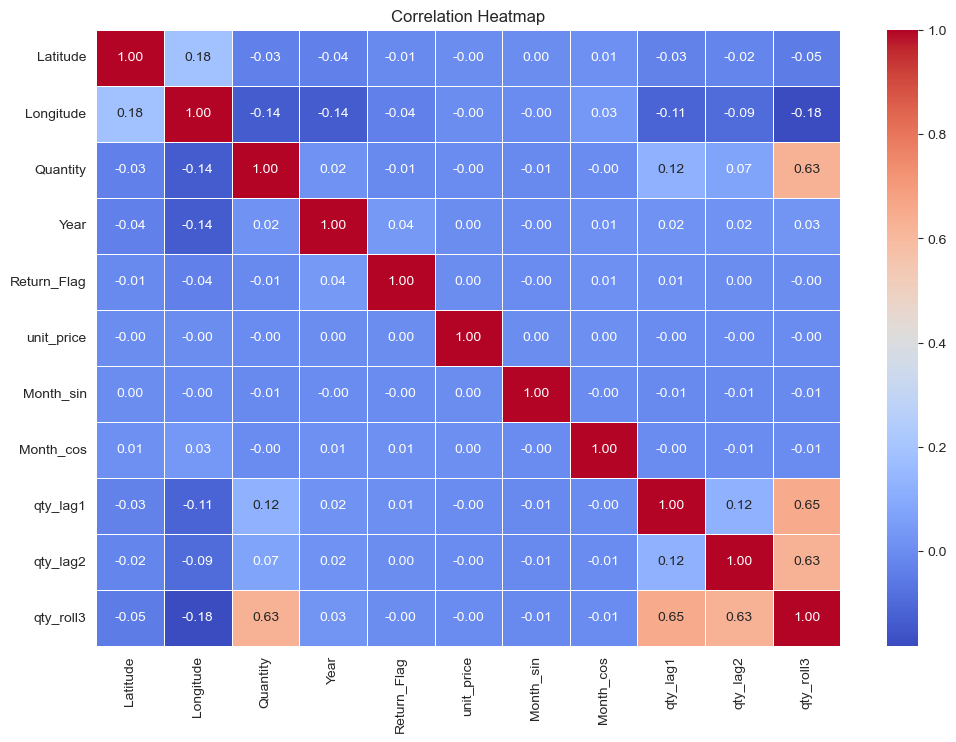

In [11]:
numeric_df = df_mod.select_dtypes(include=[np.number])

# Compute the correlation matrix on the numeric columns
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

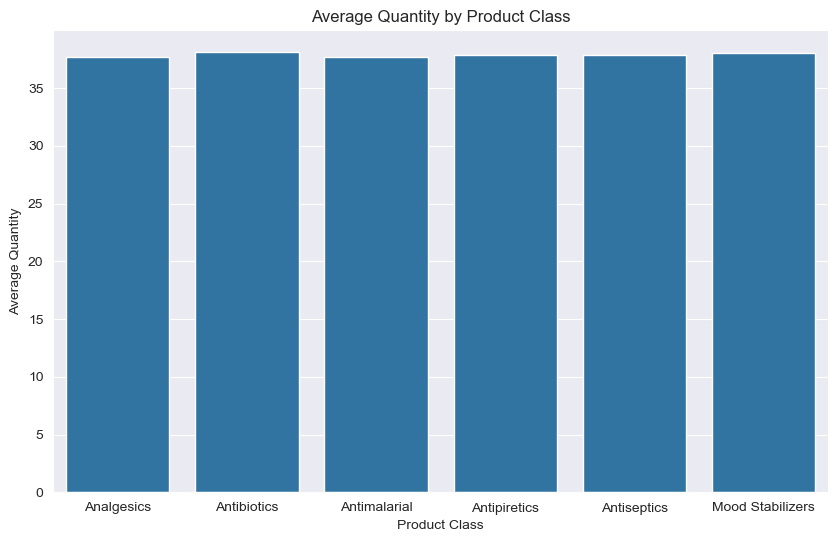

In [12]:

avg_quantity = df_mod.groupby('Product Class')['Quantity'].mean().reset_index()


plt.figure(figsize=(10, 6))


sns.barplot(x='Product Class', y='Quantity', data=avg_quantity)


plt.title('Average Quantity by Product Class')
plt.xlabel('Product Class')
plt.ylabel('Average Quantity')


plt.show()


In [13]:
print(df_mod['Year'].unique())

[2017 2018 2019 2020]


### Cut off Dataset

By splitting the dataset into training (2017-2019) and testing (2020) periods, we ensure that the model is trained on historical data and evaluated on more recent, unseen data from the year 2020.

In [14]:
train_data = df_mod[df_mod['Year'] < 2020].copy()
test_data = df_mod[df_mod['Year'] >= 2020].copy()

In [15]:
# train_mod = preprocess_dataframe(train_data)
# test_mod  = preprocess_dataframe(test_data)

train_data.drop(columns=['Year'], inplace=True)
test_data.drop(columns=['Year'], inplace=True)

In [16]:
region_cols = [c for c in train_data.columns if c.startswith('Region_')]
train_data[region_cols] = train_data[region_cols].astype(int)
test_data[region_cols] = test_data[region_cols].astype(int)

In [17]:
train_data.tail(2)

,Distributor,Country,Latitude,Longitude,Channel,Sub-channel,Product Name,Product Class,Quantity,Return_Flag,unit_price,Month_sin,Month_cos,qty_lag1,qty_lag2,qty_roll3,Region_1,Region_2,Region_3,Region_4
202609,Koss,Germany,49.8917,10.8917,Pharmacy,Institution,Zyvance,Analgesics,117.5,0,323.0,-2.449294e-16,1.0,117.5,117.5,117.500000,0,1,0,0
202780,Koss,Germany,52.4022,13.2706,Hospital,Private,Zyvance,Analgesics,12.0,0,323.0,-2.449294e-16,1.0,117.5,117.5,82.333333,0,0,1,0


In [18]:
test_data.tail(2)

,Distributor,Country,Latitude,Longitude,Channel,Sub-channel,Product Name,Product Class,Quantity,Return_Flag,unit_price,Month_sin,Month_cos,qty_lag1,qty_lag2,qty_roll3,Region_1,Region_2,Region_3,Region_4
253331,Koss,Germany,53.4714,7.4836,Pharmacy,Institution,Zyvance,Analgesics,117.5,0,323.0,-2.449294e-16,1.0,117.5,8.0,81.000000,0,0,0,0
253618,Koss,Germany,50.9500,7.3000,Hospital,Government,Zyvance,Analgesics,62.5,1,323.0,-2.449294e-16,1.0,117.5,117.5,99.166667,0,0,0,1


In [19]:
numerical_cols = train_data.select_dtypes(include=['number']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in ['Quantity']]
numerical_cols

['Latitude',
 'Longitude',
 'Return_Flag',
 'unit_price',
 'Month_sin',
 'Month_cos',
 'qty_lag1',
 'qty_lag2',
 'qty_roll3',
 'Region_1',
 'Region_2',
 'Region_3',
 'Region_4']

In [20]:
categorical_cols=train_data.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols

['Distributor',
 'Country',
 'Channel',
 'Sub-channel',
 'Product Name',
 'Product Class']

In [ ]:
train_data[categorical_cols] = train_data[categorical_cols].astype('category')
test_data[categorical_cols] = test_data[categorical_cols].astype('category')

### Data Splitting and Feature Selection

In this step, we separate the dataset into **features** (independent variables) and the **target variable** (dependent variable). We perform this split for both the training and testing datasets.

In [22]:
feature_cols = [c for c in train_data.columns if c != 'Quantity']

X_train = train_data[feature_cols]
y_train = train_data['Quantity']

X_test  = test_data[feature_cols]
y_test  = test_data['Quantity']


print("Feature columns (including Region dummies):")
print(feature_cols)
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

Feature columns (including Region dummies):
['Distributor', 'Country', 'Latitude', 'Longitude', 'Channel', 'Sub-channel', 'Product Name', 'Product Class', 'Return_Flag', 'unit_price', 'Month_sin', 'Month_cos', 'qty_lag1', 'qty_lag2', 'qty_roll3', 'Region_1', 'Region_2', 'Region_3', 'Region_4']
X_train shape: (202858, 19), X_test shape: (51193, 19)


#### Model Selection: Tree-Based Algorithms for Predicting Quantity

To predict the quantity values, we decided to leverage the power of machine learning, specifically focusing on tree-based algorithms. These models are ideal for capturing complex relationships in data, especially when dealing with non-linear patterns and large feature spaces.


In [23]:

models = {
    'Decision Tree': DecisionTreeRegressor(
        max_depth=7,
        min_samples_leaf=5,
        random_state=42
    ),
    'Random Forest': RandomForestRegressor(
        n_estimators=100,
        max_depth=7,
        max_samples=0.8,
        n_jobs=-1,
        random_state=42
    ),
    "XGBoost": XGBRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        tree_method='hist',
        n_jobs=-1,
        random_state=42
    ),
    "LightGBM": LGBMRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        feature_fraction=0.8,  
        n_jobs=-1,
        random_state=42,
        verbose=-1
    ),
    "CatBoost": CatBoostRegressor(
        iterations=200,
        depth=6,
        learning_rate=0.1,
        subsample=0.8,
        thread_count=-1,
        silent=True,
        random_state=42
    )
}

### Building the Preprocessing Pipeline

The`build_preprocessor` function creates a preprocessing pipeline for numerical and categorical features. The purpose of this function is to apply different transformations to the numerical and categorical features based on the model being used, ensuring that the data is in the optimal format for training.

In [24]:
def build_preprocessor(num_cols, cat_cols, model_name):
    # Common numeric transformer
    transformers = [('num', StandardScaler(), num_cols)]

    # Categorical transformer depends on model
    if model_name in ['LightGBM', 'CatBoost', 'XGBoost']:
        transformers.append((
            'cat', OrdinalEncoder(
                handle_unknown='use_encoded_value',
                unknown_value=-1
            ), cat_cols
        ))
    else:
        transformers.append((
            'cat', OneHotEncoder(
                handle_unknown='ignore',
                sparse_output=False
            ), cat_cols
        ))

    return ColumnTransformer(transformers)

### Evaluating a Model with Cross-Validation

The `evaluate_model` function is assess how well a specific model performs using cross-validation. This function trains the model, applies preprocessing, and evaluates its performance based on **RMSE (Root Mean Squared Error)** and **R² (R-squared)**.

In [25]:
def evaluate_model(name, model, x_t, y_t, num_cols, cat_cols):
    preprocessor = build_preprocessor(num_cols, cat_cols, name)


    if name == 'LightGBM':
        cat_indices = list(range(len(num_cols), len(num_cols) + len(cat_cols)))
        model.set_params(categorical_feature=cat_indices)

    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ], memory='./cache')


    scores = cross_validate(
        pipe,
        x_t, y_t,
        cv=5,
        scoring=['neg_root_mean_squared_error', 'r2'],
        return_train_score=False,
        n_jobs=1
    )

    return {
        'Model': name,
        'RMSE': -scores['test_neg_root_mean_squared_error'].mean(),
        'R2': scores['test_r2'].mean(),
    }


### Evaluating All Models

This `evaluate_all_models` function iterates over a dictionary of tree-based models, evaluates each one using cross-validation, and then presents the results in a sorted table based on RMSE (Root Mean Squared Error).

In [26]:
def evaluate_all_models(tree_models, x_t, y_t, num_cols, cat_cols):

    results = []
    for name, model in tree_models.items():
        print(f"Evaluating {name}...")
        res = evaluate_model(name, model, x_t, y_t, num_cols, cat_cols)
        results.append(res)


    evaluation_results = pd.DataFrame(results).sort_values(by='RMSE')

    return evaluation_results

### Evaluating All Models on the Training Data

Assess the performance of each model on the training set (`X_train` and `y_train`).

In [27]:
results_df = evaluate_all_models(models, X_train, y_train, numerical_cols, categorical_cols)
print(results_df)

Evaluating Decision Tree...
Evaluating Random Forest...
Evaluating XGBoost...
Evaluating LightGBM...


C:\Users\88017\anaconda3\Lib\site-packages\lightgbm\basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
C:\Users\88017\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\88017\anaconda3\Lib\site-packages\lightgbm\basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
C:\Users\88017\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\88017\anaconda3\Lib\site-packages\lightgbm\

Evaluating CatBoost...
           Model      RMSE        R2
2        XGBoost  1.706669  0.998301
4       CatBoost  2.035531  0.997583
3       LightGBM  2.480970  0.996408
1  Random Forest  6.637377  0.974284
0  Decision Tree  8.378844  0.959050


In [28]:
results_dict = results_df.to_dict(orient='records')

best_model_name=min(results_dict, key=lambda x: x['RMSE'])['Model']
print(f"Best model (lowest RMSE): {best_model_name}")

Best model (lowest RMSE): XGBoost


### Tuning XGBoost Hyperparameters Using Bayesian Optimization

We use **Bayesian Optimization** to fine-tune the hyperparameters of the XGBoost model. This method helps us efficiently search through the hyperparameter space to find the best combination that maximizes model performance.

In [29]:
def tune_xgboost(x_t, y_t, num_cols, cat_cols):
    # hyperparameter bounds for Bayesian Optimization
    pbounds = {
        'max_depth': (3, 10),
        'learning_rate': (0.01, 0.3),
        'subsample': (0.5, 0.95),
        'colsample_bytree': (0.5, 0.95),
        'gamma': (0, 5),
        'reg_lambda': (0, 1)
    }

    #cross-validation function
    def xgb_cv(max_depth, learning_rate, subsample, colsample_bytree, gamma, reg_lambda):
        model = XGBRegressor(
            n_estimators=200,
            max_depth=int(max_depth),
            learning_rate=learning_rate,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            gamma=gamma,
            reg_lambda=reg_lambda,
            tree_method='hist',
            n_jobs=-1,
            random_state=42
        )
        # Create a pipeline that includes preprocessing and the model
        pipe = Pipeline([
            ('preprocessor', build_preprocessor(num_cols, cat_cols, 'XGBoost')),
            ('model', model)
        ])
        # Perform 5-fold cross-validation and return the average RMSE score
        return np.mean(
            cross_val_score(
                pipe, x_t, y_t,
                scoring='neg_root_mean_squared_error',
                cv=5,
                n_jobs=1
            )
        )

    #Set up Bayesian Optimization to tune hyperparameters
    optimizer = BayesianOptimization(
        f=xgb_cv,
        pbounds=pbounds,
        random_state=42,
        verbose=2
    )

    optimizer.maximize(init_points=5, n_iter=20)

    best_params = optimizer.max['params']
    best_params['max_depth'] = int(best_params['max_depth'])

    return best_params


best_params = tune_xgboost(X_train, y_train, numerical_cols, categorical_cols)
print("Best parameters found:", best_params)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | reg_la... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | -2.515    | 0.6685    | 4.754     | 0.2223    | 7.191     | 0.156     | 0.5702    |
| 2         | -3.127    | 0.5261    | 4.331     | 0.1843    | 7.957     | 0.02058   | 0.9365    |
| 3         | -3.734    | 0.8746    | 1.062     | 0.06273   | 4.284     | 0.3042    | 0.7361    |
| 4         | -2.79     | 0.6944    | 1.456     | 0.1874    | 3.976     | 0.2921    | 0.6649    |
| 5         | -2.269    | 0.7052    | 3.926     | 0.06791   | 6.6       | 0.5924    | 0.5209    |
| 6         | -2.172    | 0.8391    | 4.288     | 0.1811    | 5.564     | 0.441     | 0.8538    |
| 7         | -2.258    | 0.812     | 4.215     | 0.1583    | 5.774     | 0.4715    | 0.7865    |
| 8         | -2.009    | 0.8357    | 4.833     | 0.283     | 5.795     | 0.1809    | 0.8796    |
| 9         | -26.04

### Final Model Training and Evaluation

After selecting the best **XGBoost** model based on hyperparameter tuning, we proceed with the final steps to train the model on the entire training dataset and prepare it for future predictions. Here's a step-by-step breakdown of the process:


In [30]:
# Build the preprocessing pipeline for the XGBoost model
preprocessor = build_preprocessor(
    numerical_cols, categorical_cols, 'XGBoost'
)
# Fit the preprocessor to the training data
preprocessor.fit(X_train)

# Transform the training and test data using the fitted preprocessor
X_train_trans = preprocessor.transform(X_train)
X_test_trans  = preprocessor.transform(X_test)

# Initialize the final XGBoost model with optimized hyperparameters
final_xgb = XGBRegressor(
    **best_params,
    n_estimators=2000,
    tree_method='hist',
    random_state=42,
    eval_metric='rmse',
    early_stopping_rounds=50,
    callbacks=[callback.EarlyStopping(
        rounds=50,
        save_best=True
    )]
)
# Train the model on the transformed training data
final_xgb.fit(
    X_train_trans, y_train,
    eval_set=[(X_test_trans, y_test)],
    verbose=True
)
# Create a final pipeline that includes preprocessing and the trained model
final_pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', final_xgb)
])


[0]	validation_0-rmse:30.92905
[1]	validation_0-rmse:22.38433
[2]	validation_0-rmse:16.43543
[3]	validation_0-rmse:16.34637
[4]	validation_0-rmse:12.16831
[5]	validation_0-rmse:9.22784
[6]	validation_0-rmse:7.20353
[7]	validation_0-rmse:5.82374
[8]	validation_0-rmse:4.91133
[9]	validation_0-rmse:4.30720
[10]	validation_0-rmse:3.90874
[11]	validation_0-rmse:3.84713
[12]	validation_0-rmse:3.67868
[13]	validation_0-rmse:3.41494
[14]	validation_0-rmse:3.19721
[15]	validation_0-rmse:3.07187
[16]	validation_0-rmse:2.97295
[17]	validation_0-rmse:2.90360
[18]	validation_0-rmse:2.80725
[19]	validation_0-rmse:2.76780
[20]	validation_0-rmse:2.69559
[21]	validation_0-rmse:2.66292
[22]	validation_0-rmse:2.62782
[23]	validation_0-rmse:2.60355
[24]	validation_0-rmse:2.57518
[25]	validation_0-rmse:2.55448
[26]	validation_0-rmse:2.53907
[27]	validation_0-rmse:2.52986
[28]	validation_0-rmse:2.50988
[29]	validation_0-rmse:2.49643
[30]	validation_0-rmse:2.47839
[31]	validation_0-rmse:2.43729
[32]	validati

### Model Evaluation: Assessing the Test Set Performance

Now we evaluate model performance on the **test set**. This helps us understand how well the model generalizes to unseen data.

In [42]:
#the final trained model to make predictions on the test set
y_pred = final_pipeline_xgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test R²:   {r2:.4f}")

Test RMSE: 1.3873
Test R²:   0.9989


### Model Performance Evaluation: RMSE and R²

- **Test RMSE**: **1.3873** on average, the model’s predictions are off by just **1.39 units**,Indicates that the our model is making predictions very close to the actual values.

- **Test R²**: **0.9989** the model explains an **amazing 99.89%** of the variance in the data, indicates that our model **nearly perfectly predicts** the target variable.



In [44]:
#Baseline prediction: always predict the training‐set mean
y_mean = y_train.mean()
y_pred_baseline = np.full_like(y_test, y_mean, dtype=float)

rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
r2_baseline   = r2_score(y_test, y_pred_baseline)

print(f"Baseline RMSE: {rmse_baseline:.4f}")
print(f"Baseline R²:   {r2_baseline:.4f}")

Baseline RMSE: 42.9604
Baseline R²:   -0.0105


### Baseline Performance Evaluation: RMSE and R²

- **Baseline RMSE**: **58.0665** on average, the model’s predictions are off by **42.96 units**,which is much higher than our **XGBoost model’s RMSE** of 1.39. This shows that our model is significantly more accurate.

- **Baseline  R²**: **-0.0105** The baseline model has an **R² close to 0** (and even negative), indicating it explains almost no variance in the data.

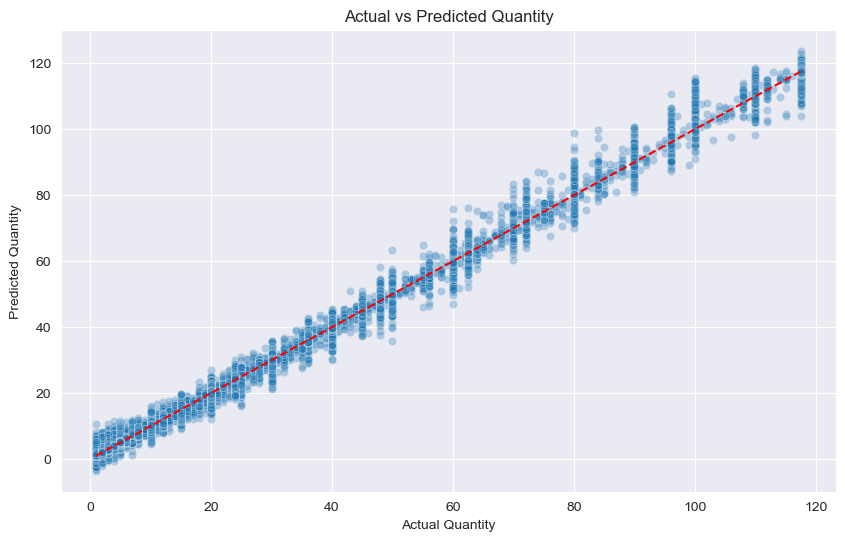

In [45]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual Quantity")
plt.ylabel("Predicted Quantity")
plt.title("Actual vs Predicted Quantity")
plt.grid(True)
plt.show()

##### In the figure, we observe that the close alignment of the scatter points with the red dashed line indicates that our model is performing very well. Most of the predicted values are very close to the actual values, which is consistent with the high R² value (0.9989) and low RMSE (1.3873) we've achieved.


### Residual Plot: Visualizing Model Errors

A **residual plot** helps us understand how well the model is performing by visualizing the errors (residuals) between the actual and predicted values. Here's what we learn from this plot:


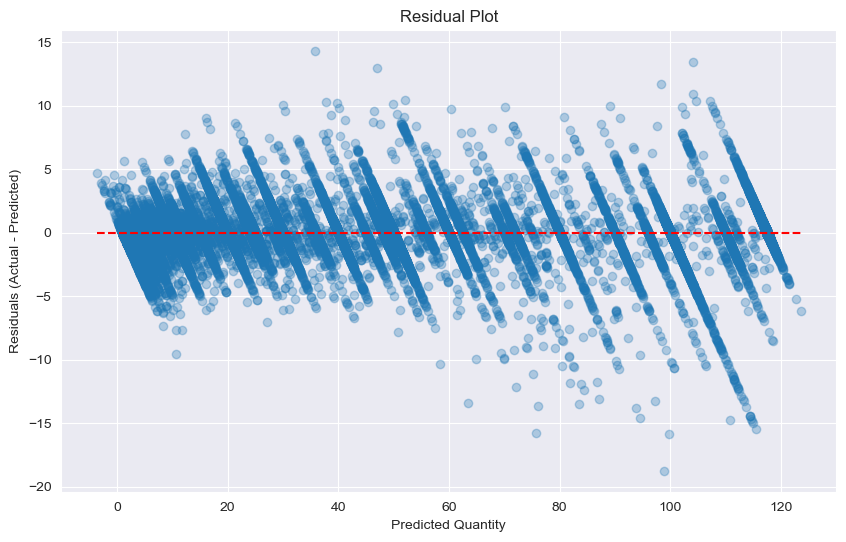

In [46]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.3)
plt.hlines(0, xmin=y_pred.min(), xmax=y_pred.max(), colors='red', linestyle='--')
plt.xlabel("Predicted Quantity")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.grid(True)
plt.show()

#### Residual Plot Insights

The **residual plot** shows that the model performs well for lower quantities, with errors staying small. However, as predicted quantities increase, the residuals spread out, indicating larger errors. This suggests the model **struggles with higher quantities**, likely due to **non-linear patterns** or **limited data** at higher ranges.



### Analyzing Feature Importance with XGBoost

After training our **XGBoost model**, it's important to understand which features are driving the model's predictions. By examining **feature importance**, we can identify the most influential features for our target variable.




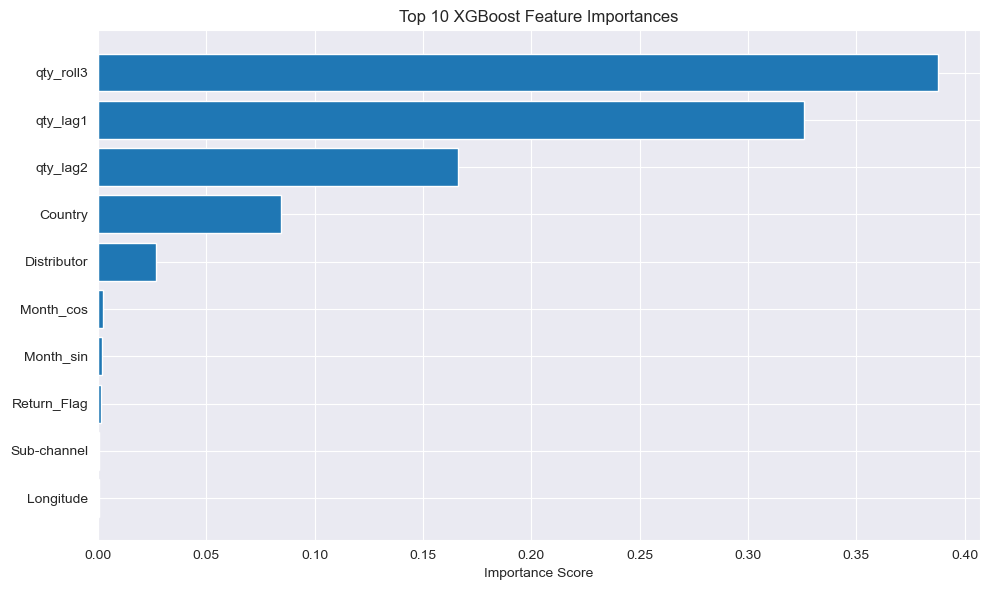

In [35]:
# Access the fitted model from your pipeline
xgb_model = final_pipeline_xgb.named_steps['model']

# Get feature names from the preprocessor
# OneHotEncoder creates multiple columns per categorical feature
preprocessor = final_pipeline_xgb.named_steps['preprocessor']
num_features = preprocessor.transformers_[0][2]
cat_encoder = preprocessor.transformers_[1][1]
cat_features = cat_encoder.get_feature_names_out(preprocessor.transformers_[1][2])

all_feature_names = list(num_features) + list(cat_features)

# Get feature importances
importances = xgb_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

#  Plot top 20 features
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10][::-1], importance_df['Importance'][:10][::-1])
plt.xlabel('Importance Score')
plt.title('Top 10 XGBoost Feature Importances')
plt.tight_layout()
plt.show()

##### The plot reveals that historical quantity data (like qty_roll3, qty_lag1, and qty_lag2) plays a crucial role in making accurate predictions, with past sales patterns being the most important factor. Geographical features like Country and Distributor, along with seasonality (captured through Month_sin and Month_cos), also contribute significantly. Additionally, the Return_Flag feature, indicating whether an item is a return, is important, showing that returns have a noticeable impact on predicting future quantities. Overall, both historical data and business/contextual features drive the model's performance.

### Understanding Model Predictions with SHAP

To gain deeper insights into how our **XGBoost model** makes predictions, we use **SHAP (SHapley Additive exPlanations)** values. SHAP helps us explain the contribution of each feature to a given prediction

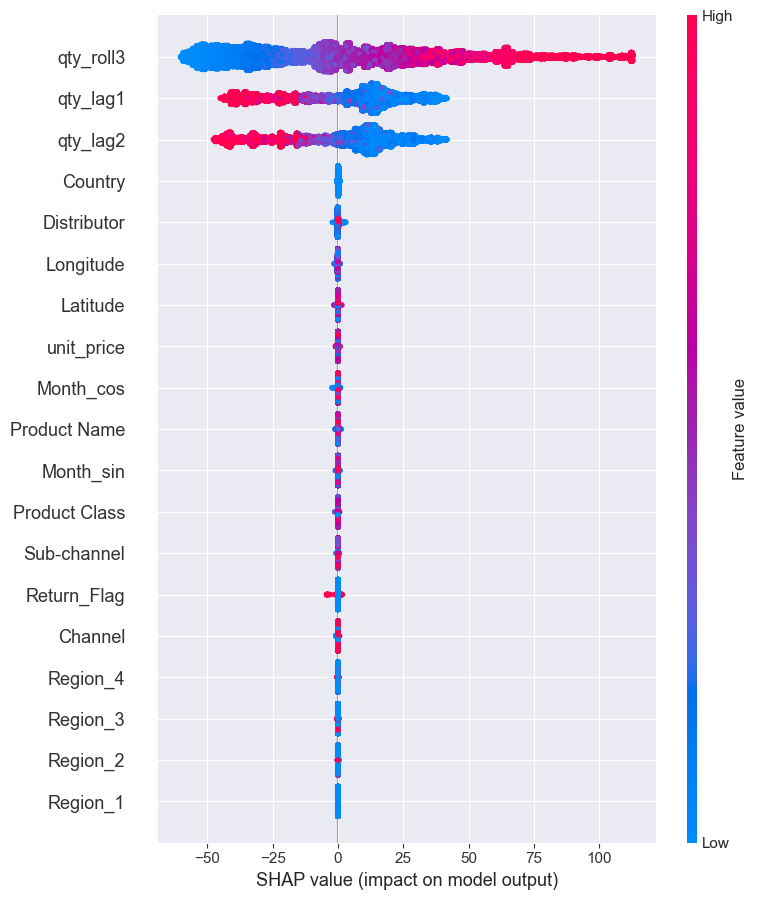

In [36]:

explainer = shap.TreeExplainer(xgb_model)

shap_values = explainer.shap_values(X_test_trans)

shap.summary_plot(shap_values, X_test_trans, feature_names=all_feature_names)

#### This plot reveals which features the XGBoost model relies on most when making predictions. Features like recent sales (lag and rolling quantities) have the strongest impact, followed by geographical and business-related factors such as distributor and return flags. This transparency helps us interpret the model's decision-making process and ensures that important patterns in the data are being captured.

In [37]:
#svae trained model
joblib.dump(final_pipeline_xgb, 'final_xgb_pipeline.pkl')

['final_xgb_pipeline.pkl']